In [1]:
import numpy as np
import sep
import astropy

In [2]:
# additional setup for reading the test image and displaying plots
import astropy
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [4]:
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

image_file = get_pkg_data_filename('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits')

In [5]:
fits.info(image_file)

Filename: hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     358   (3600, 3600)   float32   


In [8]:
data2 = fits.getdata(image_file, ext=0)

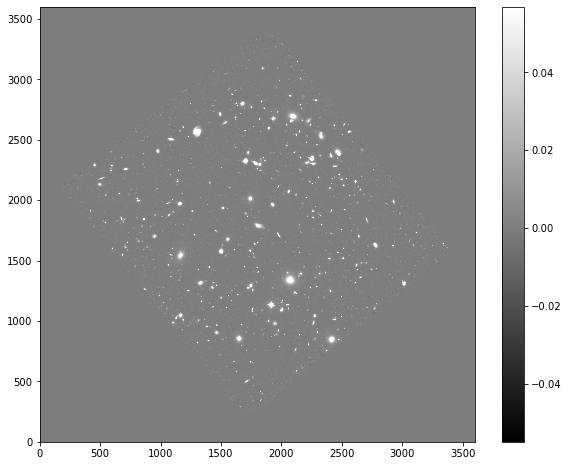

In [9]:
# show the image
m, s = np.mean(data2), np.std(data2)
plt.imshow(data2, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig("f125w.png")

In [10]:
# measure a spatially varying background on the image
data2 = data2.byteswap().newbyteorder()
bkg = sep.Background(data2)

In [11]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0007103732204996049


In [12]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
#bkg_image = np.array(bkg) # equivalent to above

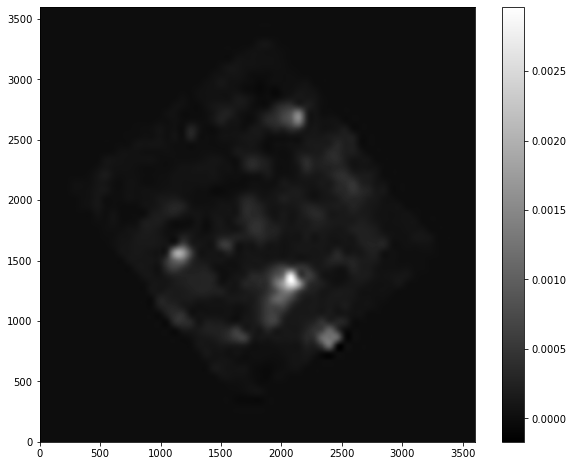

In [13]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig("f125w_background.png")

In [14]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

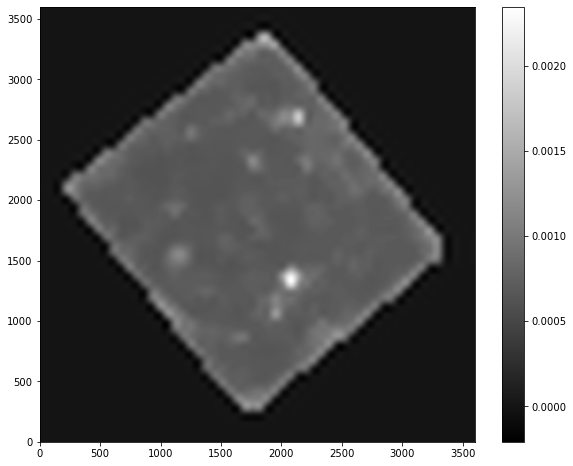

In [15]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig("f125w_background_noise.png")

In [17]:
# subtract the background
data_sub = data2 - bkg

In [18]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [19]:
# how many objects were detected
len(objects)

7480

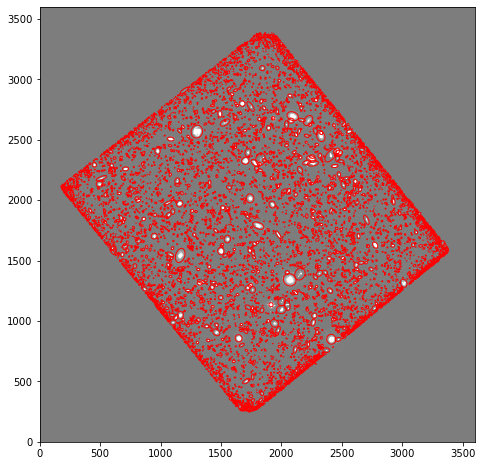

In [21]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig("f125w_background-subtracted.png")

In [22]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [23]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.036277 +/- 0.190503
object 1: flux = 0.006989 +/- 0.083685
object 2: flux = 0.009308 +/- 0.096552
object 3: flux = 0.043034 +/- 0.207480
object 4: flux = 0.020212 +/- 0.142220
object 5: flux = 0.033855 +/- 0.184037
object 6: flux = 0.054143 +/- 0.232716
object 7: flux = 0.035985 +/- 0.189736
object 8: flux = 0.007299 +/- 0.085517
object 9: flux = 0.058568 +/- 0.242037


(array([7.474e+03, 4.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-1.51081895e-02,  8.12387198e+01,  1.62492548e+02,  2.43746376e+02,
         3.25000204e+02,  4.06254032e+02,  4.87507860e+02,  5.68761688e+02,
         6.50015516e+02,  7.31269344e+02,  8.12523172e+02]),
 <BarContainer object of 10 artists>)

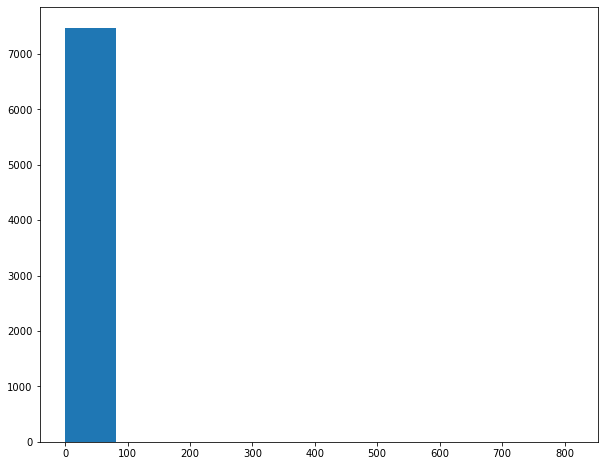

In [24]:
plt.hist(flux)